In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import optim
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.helpers.tokenizer import CharNgramTokenizer
from torchlake.common.helpers.transform import CustomVocabTransform
from torchlake.common.helpers.vocab import CharNgramVocab
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import is_longer_text
from torchlake.language_model.constants.enum import LossType
from torchlake.text_classification.datasets.ag_news.constants import \
    CLASS_NAMES as AG_NEWS_CLASS_NAMES
from torchlake.text_classification.models import FastText
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import AG_NEWS

To utilize this notebook, you have to install `portalocker`, `spacy` first

# setting


In [2]:
DATASET_NAME = "AGNews"

In [3]:
artifact_path = Path('../../artifacts/fasttext')
artifact_dataset_path = artifact_path / DATASET_NAME
data_path = Path('../../data') / DATASET_NAME

In [4]:
NUM_CLASS = len(AG_NEWS_CLASS_NAMES)

In [5]:
CONTEXT = NlpContext(
    max_seq_len=256, # word length, not ngram length
)

In [6]:
BATCH_SIZE = 32
MINIMUM_LENGTH = 5

In [7]:
DEVICE = torch.device(CONTEXT.device)

In [8]:
BUCKET_SIZE = 10**5 # should be smaller than vocab size + ngram size

In [9]:
tokenizer = get_tokenizer('basic_english')

In [10]:
ngram_vocab = CharNgramVocab(BUCKET_SIZE, context=CONTEXT)
ngram_tokenizer = CharNgramTokenizer(tokenizer, ngram_vocab, ngrams=[2])

In [11]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    ngram_transform=None,
    word_transform=None,
    word_spans_transform=None,
):
    datapipe = (
        datapipe
        .map(lambda pair: (pair[1], pair[0])) # label, text -> text, label
        .map(lambda pair: (pair[0].strip(), pair[1]))
        .map(lambda pair: (pair[0].lower(), pair[1]))
        .filter(lambda pair: is_longer_text(pair[0], minimum_length))
        .map(
            lambda pair: (ngram_tokenizer(pair[0]), pair[1])
        )  # label, (grams, words, word_spans)
    )

    if ngram_transform:
        datapipe = datapipe.map(
            lambda pair: (
                (
                    ngram_transform(pair[0][0]),
                    word_transform(pair[0][1]),
                    word_spans_transform(pair[0][2]),
                ),
                pair[1] - 1,
            )  # (grams, words, word_spans), label
        )

    return datapipe

In [12]:
train_datapipe, test_datapipe = AG_NEWS(data_path.as_posix())

In [13]:
# create vocabulary
cloned_train_datapipe = datapipe_factory(train_datapipe, MINIMUM_LENGTH)
for _ in cloned_train_datapipe:
    pass

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [14]:
def datapipe_factory_for_vocab(datapipe, minimum_length: int = 1):
    datapipe = (
        datapipe.map(lambda pair: pair[1])
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, minimum_length))
        .map(lambda text: ngram_tokenizer.tokenizer(text))
    )

    return datapipe

In [15]:
# optional for KNN search
ngram_vocab.build_word_vocab(
    datapipe_factory_for_vocab(train_datapipe, minimum_length=MINIMUM_LENGTH)
)

In [16]:
VOCAB_SIZE = len(ngram_vocab.word_vocab)
VOCAB_SIZE

30335

In [17]:
print("cache size:", len(ngram_vocab))

cache size: 99515


In [18]:
ngram_vocab.save_word_vocab(artifact_dataset_path / "words.json")
ngram_vocab.save_subword_vocab(artifact_dataset_path / "grams.json")

In [19]:
ngram_vocab.load_word_vocab(artifact_dataset_path / "words.json")
ngram_vocab.load_subword_vocab(artifact_dataset_path / "grams.json")

In [20]:
get_file_size(artifact_dataset_path / "words.json")

'0.52MB'

In [21]:
get_file_size(artifact_dataset_path / "grams.json")

'1.83MB'

In [22]:
ngram_transform = T.Sequential(
    CustomVocabTransform(ngram_vocab),
    T.ToTensor(),
)

In [23]:
word_transform = T.Sequential(
    T.Truncate(CONTEXT.max_seq_len),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [24]:
word_spans_transform = T.Sequential(
    T.Truncate(CONTEXT.max_seq_len),
    T.ToTensor(),
)

In [25]:
train_datapipe = datapipe_factory(
    train_datapipe,
    MINIMUM_LENGTH,
    ngram_transform,
    word_transform,
    word_spans_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    MINIMUM_LENGTH,
    ngram_transform,
    word_transform,
    word_spans_transform,
)

In [26]:
count = 0
for (grams, words, word_lengths), label in train_datapipe:
    print(grams.shape)
    print(words.shape)
    print(word_lengths.shape)
    print(label)
    if count > 10:
        break
    count+=1

torch.Size([104])
torch.Size([256])
torch.Size([29])
2
torch.Size([196])
torch.Size([256])
torch.Size([42])
2
torch.Size([162])
torch.Size([256])
torch.Size([40])
2
torch.Size([187])
torch.Size([256])
torch.Size([40])
2
torch.Size([163])
torch.Size([256])
torch.Size([43])
2
torch.Size([163])
torch.Size([256])
torch.Size([48])
2
torch.Size([140])
torch.Size([256])
torch.Size([47])
2
torch.Size([176])
torch.Size([256])
torch.Size([49])
2
torch.Size([275])
torch.Size([256])
torch.Size([88])
2
torch.Size([101])
torch.Size([256])
torch.Size([31])
2
torch.Size([155])
torch.Size([256])
torch.Size([44])
2
torch.Size([181])
torch.Size([256])
torch.Size([56])
2


In [27]:
NUM_WORKERS = get_num_workers()

In [28]:
def collate_fn(
    batch: list[torch.Tensor],
    device: torch.device,
) -> tuple[list[torch.Tensor], list[torch.Tensor], list[torch.Tensor], torch.Tensor]:
    ngrams, words, word_spans = [], [], []
    labels = []
    
    for (ngram, word, word_span), label in batch:
        # truncate ngram with word length
        # move to gpu here
        # TODO: more trackable some other days
        ngrams.append(ngram[:sum(word_span)].to(device))
        words.append(word)
        word_spans.append(word_span.to(device))
        labels.append(label)

    return (ngrams, torch.stack(words).to(device), word_spans), torch.LongTensor(labels).to(device)

In [29]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    # pin_memory=True,
    num_workers=NUM_WORKERS,
    collate_fn=lambda x: collate_fn(x, DEVICE),
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    # pin_memory=True,
    num_workers=NUM_WORKERS,
    collate_fn=lambda x: collate_fn(x, DEVICE),
)

In [30]:
count = 0
for (grams, words, word_spans), label in train_dataloader:
    print(len(grams), *[gram.shape for gram in grams[:4]])
    print(words.shape)
    print(len(word_spans), *[word_span.shape for word_span in word_spans[:4]])
    print(label.shape)
    if count > 10:
        break
    count+=1

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


32 torch.Size([104]) torch.Size([196]) torch.Size([162]) torch.Size([187])
torch.Size([32, 256])
32 torch.Size([29]) torch.Size([42]) torch.Size([40]) torch.Size([40])
torch.Size([32])
32 torch.Size([100]) torch.Size([110]) torch.Size([103]) torch.Size([119])
torch.Size([32, 256])
32 torch.Size([36]) torch.Size([34]) torch.Size([26]) torch.Size([32])
torch.Size([32])
32 torch.Size([216]) torch.Size([247]) torch.Size([253]) torch.Size([225])
torch.Size([32, 256])
32 torch.Size([66]) torch.Size([74]) torch.Size([68]) torch.Size([62])
torch.Size([32])
32 torch.Size([95]) torch.Size([95]) torch.Size([176]) torch.Size([228])
torch.Size([32, 256])
32 torch.Size([31]) torch.Size([35]) torch.Size([42]) torch.Size([65])
torch.Size([32])
32 torch.Size([202]) torch.Size([164]) torch.Size([130]) torch.Size([217])
torch.Size([32, 256])
32 torch.Size([51]) torch.Size([43]) torch.Size([47]) torch.Size([56])
torch.Size([32])
32 torch.Size([212]) torch.Size([197]) torch.Size([210]) torch.Size([432])
to

# training


In [31]:
EMBED_DIM = 300

In [32]:
EPOCHES = 10
ACC_ITERS = max(32 / BATCH_SIZE, 1)
LR = 1e-3

In [33]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, ACC_ITERS, feature_last=True)

In [34]:
model = FastText(
    BUCKET_SIZE,
    EMBED_DIM,
    NUM_CLASS,
    loss_type=LossType.CROSS_ENTROPY,
    context=CONTEXT,
).to(DEVICE)

In [35]:
loss = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [36]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
FastText                                 --
├─SubwordEmbedding: 1-1                  --
│    └─Embedding: 2-1                    30,000,000
│    └─Embedding: 2-2                    1,200
├─Linear: 1-2                            1,204
Total params: 30,002,404
Trainable params: 30,002,404
Non-trainable params: 0

In [37]:
training_loss = trainer.run(train_dataloader, model, optimizer, loss)

3750it [02:52, 21.75it/s]


epoch 1 : 0.3819239235520363


3750it [02:54, 21.49it/s]


epoch 2 : 0.1674368421882391


3750it [02:52, 21.73it/s]


epoch 3 : 0.13623133122101427


3750it [02:53, 21.59it/s]


epoch 4 : 0.11890580112809936


3750it [02:50, 22.04it/s]


epoch 5 : 0.10664762827306985


3750it [02:55, 21.37it/s]


epoch 6 : 0.09702322473699848


3750it [02:55, 21.39it/s]


epoch 7 : 0.08898995060970386


3750it [02:58, 21.03it/s]


epoch 8 : 0.08207345613700648


3750it [03:01, 20.66it/s]


epoch 9 : 0.07600722429653009


3750it [03:02, 20.55it/s]

epoch 10 : 0.07061235350295901


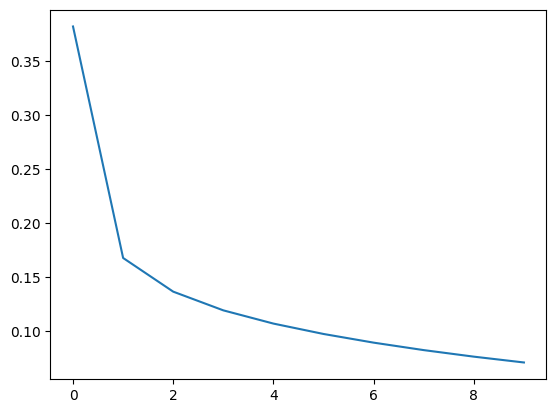

In [38]:
plt.plot(training_loss)

# Inference

In [39]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [40]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

237it [00:13, 17.52it/s]

[[1742   56   64   38]
 [  13 1870    9    2]
 [  76   17 1682  124]
 [  66   19  152 1638]]


In [41]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.9168421052631579
sports    : 0.9873284054910243
business  : 0.8857293312269615
science   : 0.8736


In [42]:
per_class_acc.mean()

0.9158749604952859

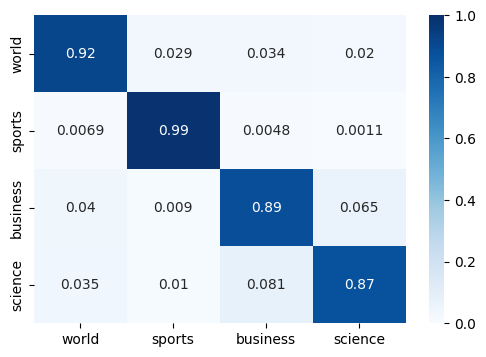

In [43]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

# File


In [44]:
model_path = artifact_path / "fasttext.pth"

In [45]:
torch.save(model.state_dict(), model_path)

In [46]:
get_file_size(model_path)

'114.45MB'

In [47]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Product Quantization

In [48]:
from torchlake.common.helpers.quantizer import ProductQuantization, get_compression_ratio

In [ ]:
quantizer = ProductQuantization(k=50)

In [118]:
vectors = model.embeddings.weight.data.clone()

In [119]:
vectors

tensor([[-0.5887, -1.5287, -0.7832,  ..., -0.3271, -1.4679,  1.3871],
        [ 0.8909, -1.2176,  0.4909,  ...,  0.0450,  1.1130, -0.9949],
        [-1.7107, -0.7182, -0.4997,  ..., -0.2353, -0.4815, -1.0157],
        ...,
        [ 1.2645,  1.6792, -0.0476,  ..., -0.0868,  0.5137,  1.9476],
        [-2.2605, -0.1781, -0.0355,  ...,  0.1853,  1.5293, -0.8034],
        [-1.2113,  0.1580,  0.7323,  ..., -1.2736,  1.9072,  2.1073]],
       device='cuda:0')

In [120]:
quantized_indices = quantizer.quantize(vectors.detach().cpu())

In [122]:
get_compression_ratio(vectors, quantizer.codebook, quantized_indices)

0.04174666666666667

In [123]:
reconstructed_vectors = quantizer.reconstruct(quantized_indices.long())

In [128]:
import torch.nn.functional as F

print("quantization error", F.mse_loss(vectors.detach().cpu(), reconstructed_vectors))

quantization error tensor(0.9336)


In [109]:
model.embeddings.weight.data.copy_(reconstructed_vectors)

tensor([[ 0.2695,  0.7591, -0.5311,  ...,  1.9347, -0.2132,  0.5362],
        [ 1.1164, -0.8147,  1.1852,  ..., -0.3755, -0.0545, -0.6657],
        [-0.6952,  0.6119, -0.1353,  ..., -0.2368, -1.1817, -0.6934],
        ...,
        [ 0.2695,  0.7591, -0.5311,  ...,  1.9347, -0.2132,  0.5362],
        [-2.1339, -0.5943, -0.1892,  ...,  0.4313,  2.1424,  0.2259],
        [-0.6952,  0.6119, -0.1353,  ...,  0.4313,  2.1424,  0.2259]],
       device='cuda:0')

## visualization

In [145]:
params = [10, 30, 50, 60, 100, 150]
errors = []
ratios = []
for k in params:
    quantizer = ProductQuantization(k=k)
    vectors = model.embeddings.weight.data.clone().detach().cpu()
    quantized_indices = quantizer.quantize(vectors)
    reconstructed_vectors = quantizer.reconstruct(quantized_indices.long())
    
    errors.append(F.mse_loss(vectors, reconstructed_vectors).item())
    ratios.append(get_compression_ratio(vectors, quantizer.codebook, quantized_indices))

Text(0, 0.5, 'quantization error')

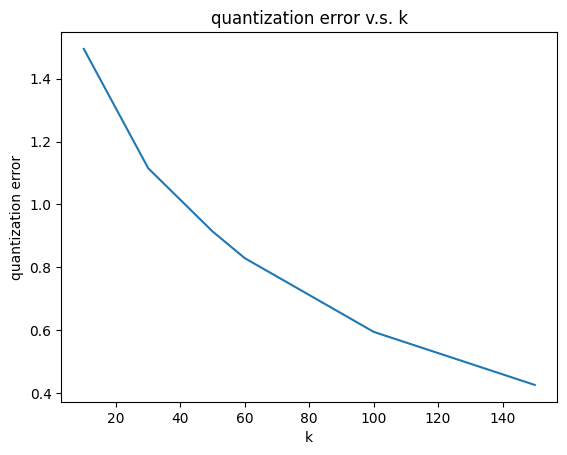

In [148]:
plt.plot(params, errors)
plt.title("quantization error v.s. k")
plt.xlabel("k")
plt.ylabel("quantization error")

Text(0, 0.5, 'compression ratio')

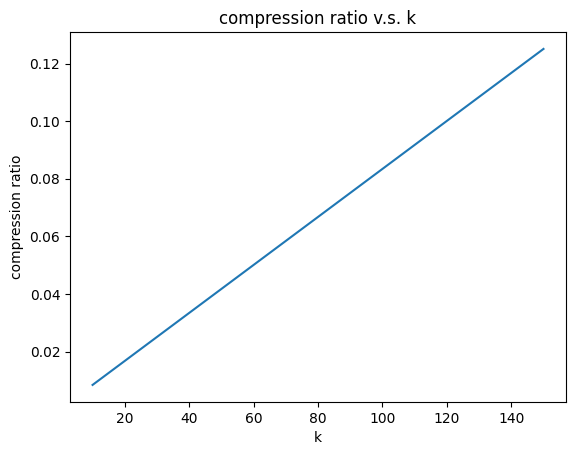

In [149]:
plt.plot(params, ratios)
plt.title("compression ratio v.s. k")
plt.xlabel("k")
plt.ylabel("compression ratio")

## Evaluation

In [110]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [111]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

7599it [00:18, 410.59it/s]

[[1137  695   34   34]
 [  34 1863    1    2]
 [ 248  790  677  184]
 [ 130  820   83  867]]


In [112]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.598421052631579
sports    : 0.9805263157894737
business  : 0.3565034228541338
science   : 0.45631578947368423


In [113]:
per_class_acc.mean()

0.5979416451872177

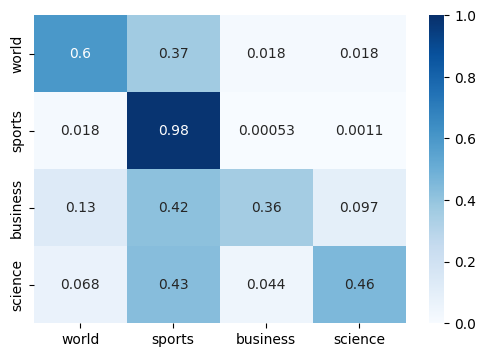

In [114]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

## retraining

In [ ]:
model.embeddings.requires_grad_(False)

In [ ]:
EPOCHES = 5
ACC_ITERS = 32 / BATCH_SIZE
LR = 1e-3

In [ ]:
trainer.run()

In [ ]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, ACC_ITERS, feature_last=True)

In [ ]:
loss = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
training_loss = trainer.run(train_dataloader, model, optimizer, loss)

In [ ]:
plt.plot(training_loss)

## file

In [ ]:
model_path = artifact_path / "fasttext.pq.pth"

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
get_file_size(model_path)

'114.45MB'

In [ ]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>